# Time series

In [97]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings('ignore')

In [9]:
############################
# Veri Seti
############################

# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

In [10]:
data = sm.datasets.co2.load_pandas() # stats modle kütüphanesinden 'co2' dataset
y = data.data # zaman serisine çevirdik 
y.head(6) # bu haftalık bir veri setidir 

# ama biz aylık yapmak istiyoruz çükü daha sağlıklı olacaktır co2 sık değişmez

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9


In [11]:
y.isnull().sum()

co2    59
dtype: int64

In [12]:
y.isnull().sum()
y.shape

(2284, 1)

In [13]:
y = y['co2'].resample('MS').mean()  # aylık bir seriye çevirdik
y 


1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [14]:
y = y.fillna(y.bfill())  
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

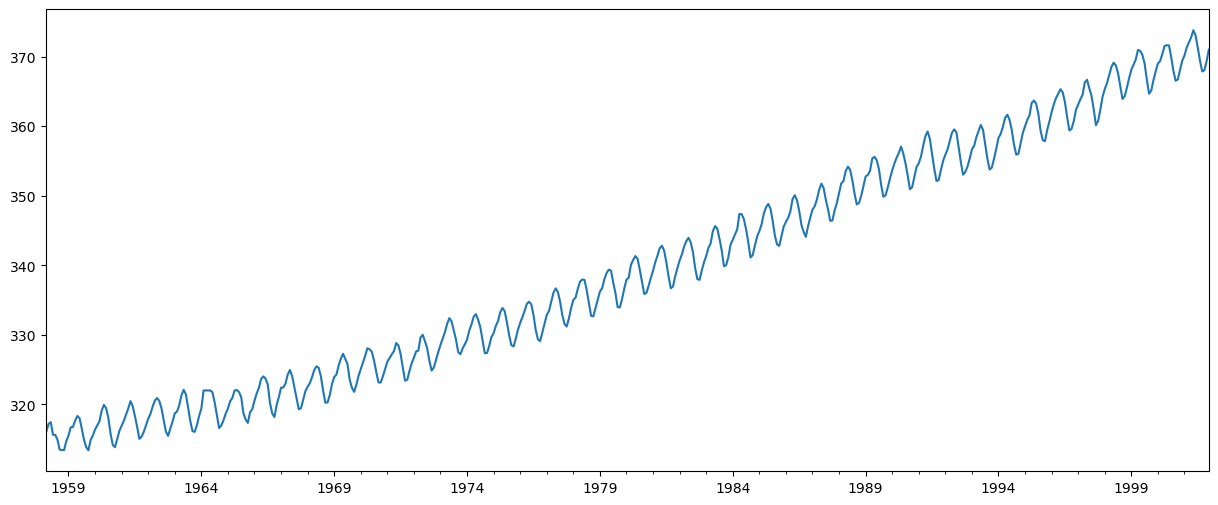

In [15]:
y.plot(figsize=(15, 6))
plt.show()
# durağanlık x, mevsimsellik ı, trend ı ? varmıdır

In [16]:
############################
# Holdout
############################

In [17]:
train = y[:'1997-12-01']
len(train)  # 478 ay

478

In [18]:
# 1998'ilk ayından 2001'in sonuna kadar test set.
test = y['1998-01-01':]
len(test)  # 48 ay

48

## Durağanlık Testi (Dickey-Fuller Testi)

In [19]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [20]:
is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


## Zaman Serisi Bileşenleri ve Durağanlık Testi

In [21]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

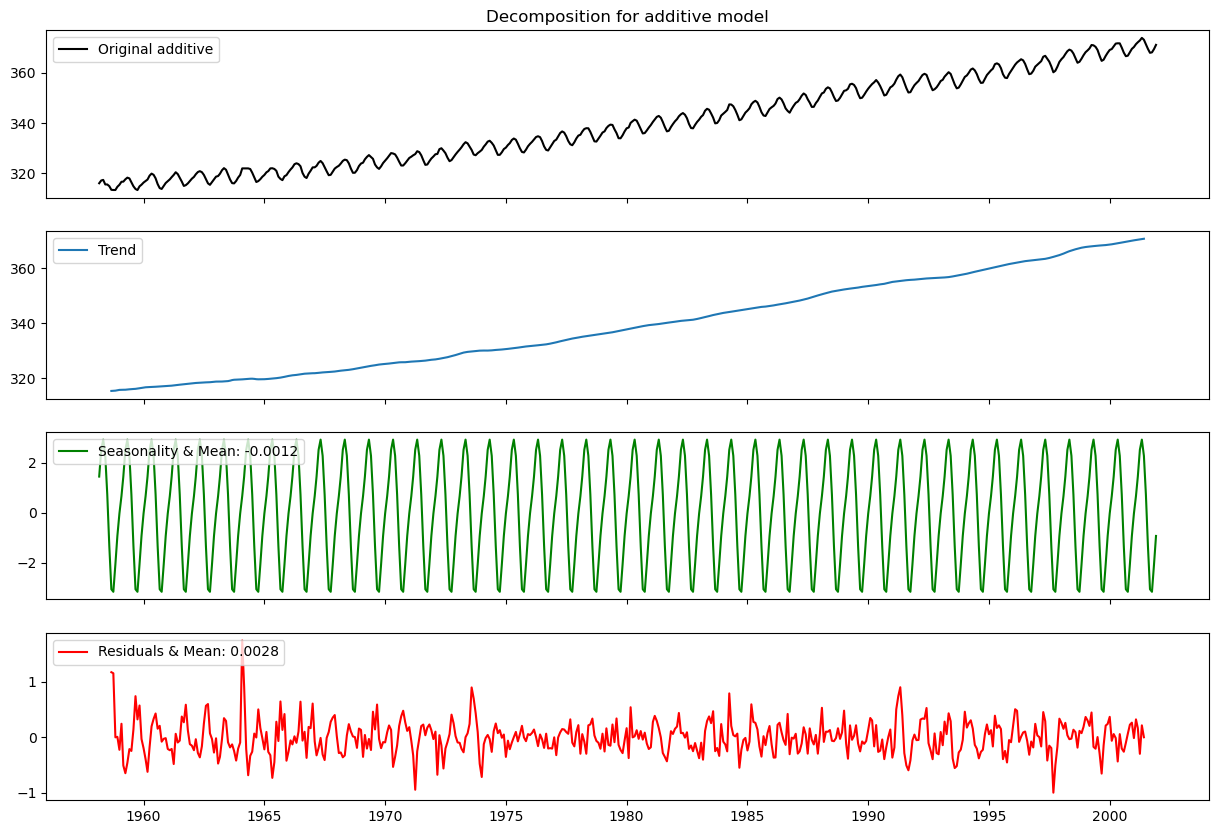

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [22]:
ts_decompose(y, stationary=True) # so grafik artıkların 0 etrafında toplanmasını isteriz

In [23]:
# alfa değerini verdik 
# ama vermeseydikte SimpleExpSmoothing metodu vermemeizin nedeni birazdan modele alfa gama gibi farklı
# değerlerde girilecek bunu tahmin etmek için yani double,triple exponential olacak  
# test seti 48 adımdı, periyottu  yani bu test seti için ayırdığımız
# 48 ay için tahminlerde bulunuyoruz 

# Single Exponential Smoothing

In [24]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5) 

In [25]:
y_pred = ses_model.forecast(48) 
y_pred.head() 

1998-01-01    363.057044
1998-02-01    363.057044
1998-03-01    363.057044
1998-04-01    363.057044
1998-05-01    363.057044
Freq: MS, dtype: float64

In [26]:
mean_absolute_error(test, y_pred)  # 

5.706393369643809

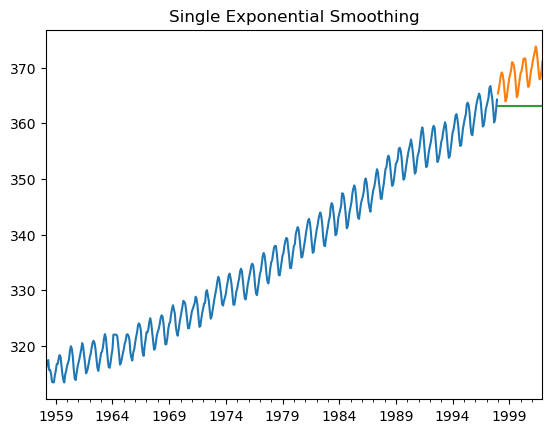

In [27]:
train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot() # evet yeşiller tahmin ve turuncular gerçek değerler yani hatalı tahminler yaptık 
plt.show()

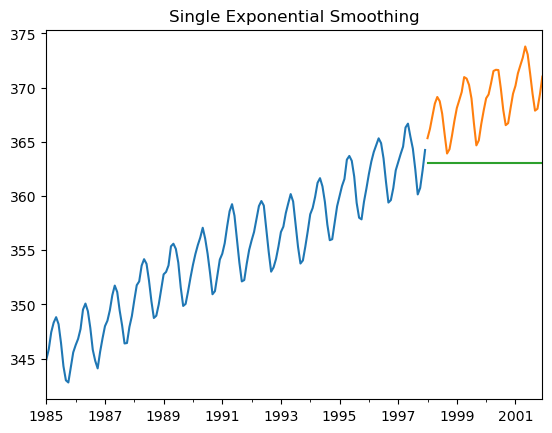

In [28]:
train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()     # aynı görsele yakından bakıyoruz
plt.show()

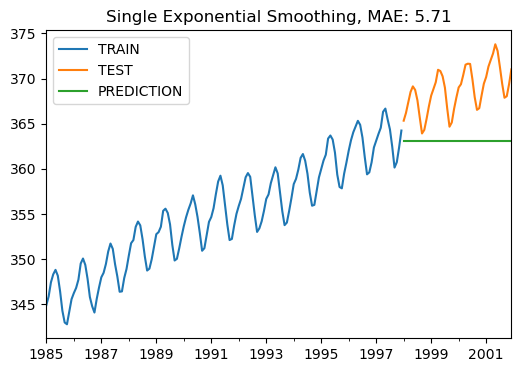

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.44193240799893,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [29]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)             
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")       # hem hata hem grafikelrin bir arada olduğu def
    plt.show()

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

ses_model.params   

In [30]:
ses_model.params  # burada parametrelere örneğin smothing_levle 0.5 girmişiz neredn biliyoruz 
                # 3 en iyisi olduğunu bunu öğrenmek için diğerlerininde denmemiz lazım denememiz lazım
    # öğrenmek için hyper parameter optimizasyonu yapacağız 

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.44193240799893,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [31]:
############################
# Hyperparameter Optimization
############################

In [32]:
def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [33]:
alphas = np.arange(0.8, 1, 0.01)  

In [34]:
# yt_sapka = a * yt-1 + (1-a)* (yt_-1)_sapka

In [35]:
ses_optimizer(train, alphas)  

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


(0.9900000000000002, 4.545056761011273)

In [36]:
print("en iyi alfa değeri:", best_alpha, "en düşük hata değeri:", best_mae)

NameError: name 'best_alpha' is not defined

In [ ]:
best_alpha, best_mae = ses_optimizer(train, alphas)

In [ ]:
print("en iyi alfa değeri:", best_alpha, "en düşük hata değeri:", best_mae)

In [37]:
############################
# Final SES Model
############################

In [41]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha) # en iyi değerler gömülü

NameError: name 'best_alpha' is not defined

In [42]:
y_pred = ses_model.forecast(48) 

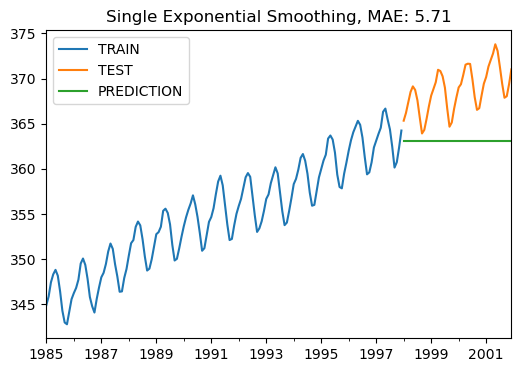

In [43]:
plot_co2(train, test, y_pred, "Single Exponential Smoothing")

# tahmin başarısı son aşamada bile çok da iyi gibi gözükmüyor 

# Double Exponential Smoothing (DES)

In [44]:
# DES: Level (SES) + Trend


# y(t) = Level + Trend + Seasonality + Noise  TOPLAMSAL MODEL

# y(t) = Level * Trend * Seasonality * Noise  ÇARPIMSAL MODEL

# NOTLAR = mEVSİMSELLİK V E ARTIK BİLEŞENLERİ TRENDDEN BAĞIMISZ GİBİ GÖZÜKÜYORSA SERİ TOPLAMSALDIR
# BAĞIMLI GİBİ GÖZÜKÜYORSA ÇARPIMSALDIR 

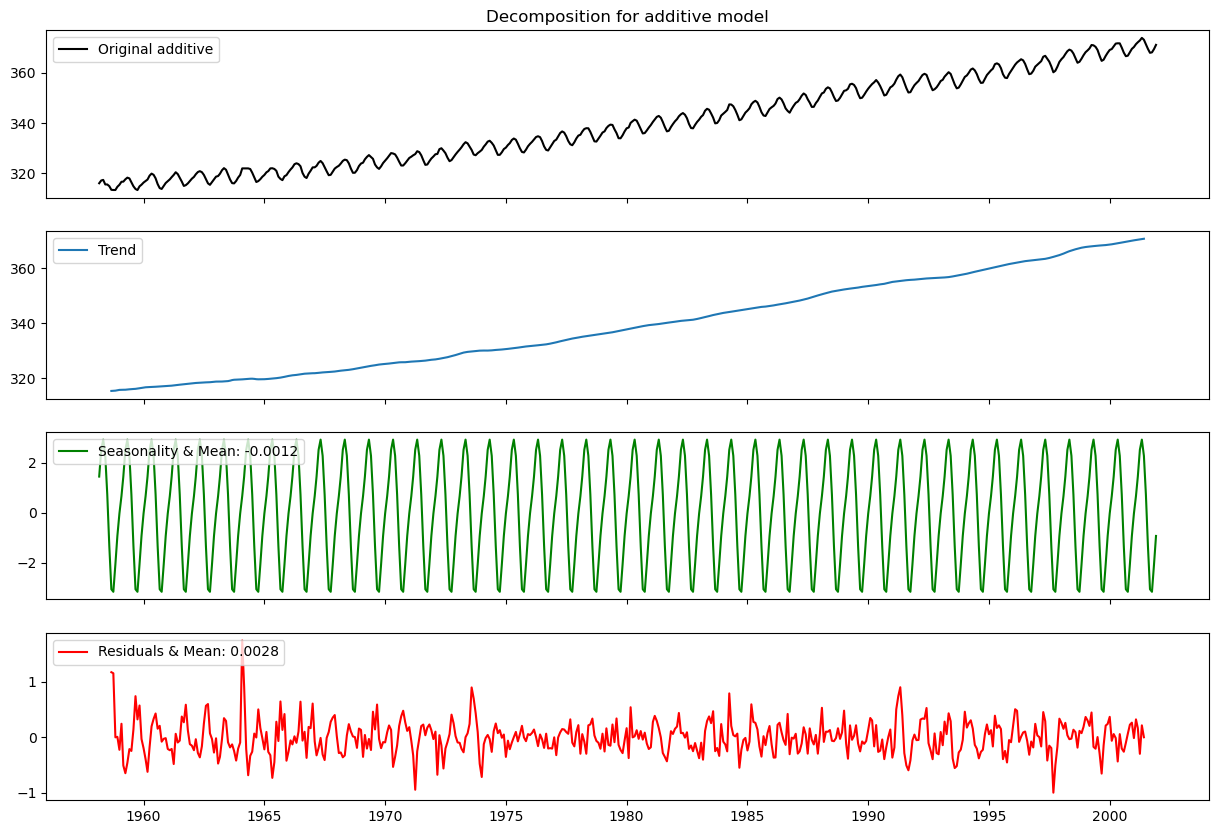

In [45]:
ts_decompose(y)  # DECOMPOSE AYRIŞTIRMAK

# GÖRÜLDÜĞÜ GİBİ TRENDİN ARTIŞ GÖSTERMESİ MEVSİMSELLİĞİ VE ARTIK DEĞERLERİ DEĞİŞTİREMEMİŞ
# İKİSİDE 0 IN ETRAFINDA İLERLİYORLAR ÇARPIMSAL VERİDİR  

In [46]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

In [47]:
y_pred = des_model.forecast(48) # BANA 48 ADET TAHMİN VER DİYORUM

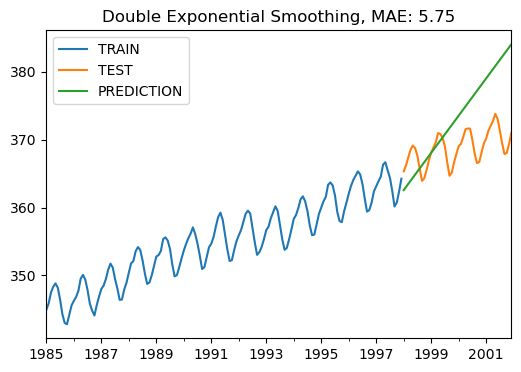

In [48]:
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

# ALDIĞIM TAHMİNLERİ GÖRSELLEŞTİRİYORUM

In [49]:
############################
# Hyperparameter Optimization
############################

In [50]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [51]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

In [52]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas) 
# en iyi değerleri bulduk

alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8522
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

In [53]:
############################
# Final DES Model
############################

In [54]:
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

In [55]:
y_pred = final_des_model.forecast(48)

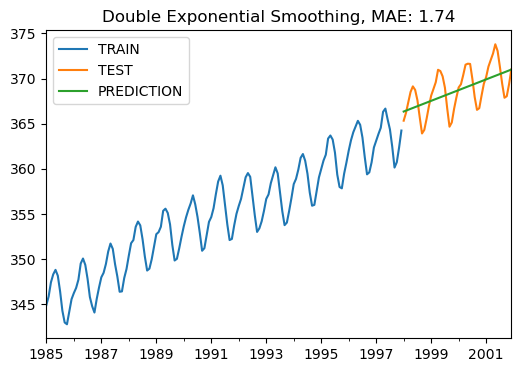

In [56]:
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

# hersey iyi gözüküyor ama hala dalgalnmaları yakalayamıyoruz yani mevsimselliği

In [57]:
##################################################
# Triple Exponential Smoothing (Holt-Winters)
##################################################

In [58]:
# TES = SES + DES + Mevsimsellik  
# TES extra mevsimsellik gelir bunuda dikkate alarak hesaplama yapar

In [59]:
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

In [60]:
y_pred = tes_model.forecast(48)

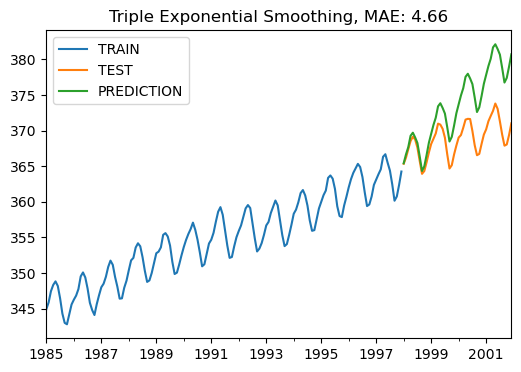

In [61]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [62]:
############################
# Hyperparameter Optimization
############################

In [63]:
alphas = betas = gammas = np.arange(0.20, 1, 0.10)

abg = list(itertools.product(alphas, betas, gammas))

In [64]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_gamma, best_mae

In [65]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.73]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.39]
[0.2, 0.4, 0.8, 11.66]
[0.2, 0.4, 0.9, 4.52]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.84]
[0.2, 0.5, 0.7, 3.35]
[0.2, 0.5, 0.8, 4.63]
[0.2, 0.5, 0.9, 3.81]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.72]
[0.2, 0.6, 0.5, 1.08]
[0.2, 0.6, 0.6, 1.64]
[0.2, 0.6, 0.7, 2.67]
[0.2, 0.6, 0.8, 8330.49]
[0.2, 0.6, 0.9, 550316248754.92]
[0.2, 0.7, 0.2, 4.72]
[0.2, 0.7, 0.3, 4.56]
[0.2, 0.7, 0.4, 6.58]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6, 1.

[0.7, 0.4, 0.9, 6.42]
[0.7, 0.5, 0.2, 5.21]
[0.7, 0.5, 0.3, 4.42]
[0.7, 0.5, 0.4, 2.54]
[0.7, 0.5, 0.5, 3.05]
[0.7, 0.5, 0.6, 4.05]
[0.7, 0.5, 0.7, 3.99]
[0.7, 0.5, 0.8, 7.31]
[0.7, 0.5, 0.9, 6.62]
[0.7, 0.6, 0.2, 6.42]
[0.7, 0.6, 0.3, 5.34]
[0.7, 0.6, 0.4, 3.31]
[0.7, 0.6, 0.5, 1.38]
[0.7, 0.6, 0.6, 2.47]
[0.7, 0.6, 0.7, 3.67]
[0.7, 0.6, 0.8, 9.82]
[0.7, 0.6, 0.9, 8.92]
[0.7, 0.7, 0.2, 7.76]
[0.7, 0.7, 0.3, 6.34]
[0.7, 0.7, 0.4, 4.47]
[0.7, 0.7, 0.5, 1.67]
[0.7, 0.7, 0.6, 1.5]
[0.7, 0.7, 0.7, 1.2]
[0.7, 0.7, 0.8, 36.27]
[0.7, 0.7, 0.9, 1.8639667125386604e+16]
[0.7, 0.8, 0.2, 9.09]
[0.7, 0.8, 0.3, 7.42]
[0.7, 0.8, 0.4, 6.18]
[0.7, 0.8, 0.5, 2.51]
[0.7, 0.8, 0.6, 0.75]
[0.7, 0.8, 0.7, 63370315.24]
[0.7, 0.8, 0.8, 3067078977701.88]
[0.7, 0.8, 0.9, 4528569293175.84]
[0.7, 0.9, 0.2, 10.43]
[0.7, 0.9, 0.3, 8.73]
[0.7, 0.9, 0.4, 8.47]
[0.7, 0.9, 0.5, 1.27]
[0.7, 0.9, 0.6, 39049.61]
[0.7, 0.9, 0.7, 222149025959.14]
[0.7, 0.9, 0.8, 99268540027282.23]
[0.7, 0.9, 0.9, 3.0242207133283104e+27]
[0.

In [71]:
############################
# Final TES Model
############################

In [72]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

In [89]:
y_pred = final_tes_model.forecast(72)
a = y_pred.tail(24)
a

2002-01-01    373.009181
2002-02-01    373.703989
2002-03-01    374.303119
2002-04-01    376.180282
2002-05-01    376.063402
2002-06-01    375.404359
2002-07-01    374.530242
2002-08-01    372.462447
2002-09-01    370.165532
2002-10-01    370.871686
2002-11-01    372.035050
2002-12-01    374.064624
2003-01-01    374.940682
2003-02-01    375.635489
2003-03-01    376.234619
2003-04-01    378.111782
2003-05-01    377.994902
2003-06-01    377.335860
2003-07-01    376.461742
2003-08-01    374.393947
2003-09-01    372.097033
2003-10-01    372.803186
2003-11-01    373.966550
2003-12-01    375.996124
Freq: MS, dtype: float64

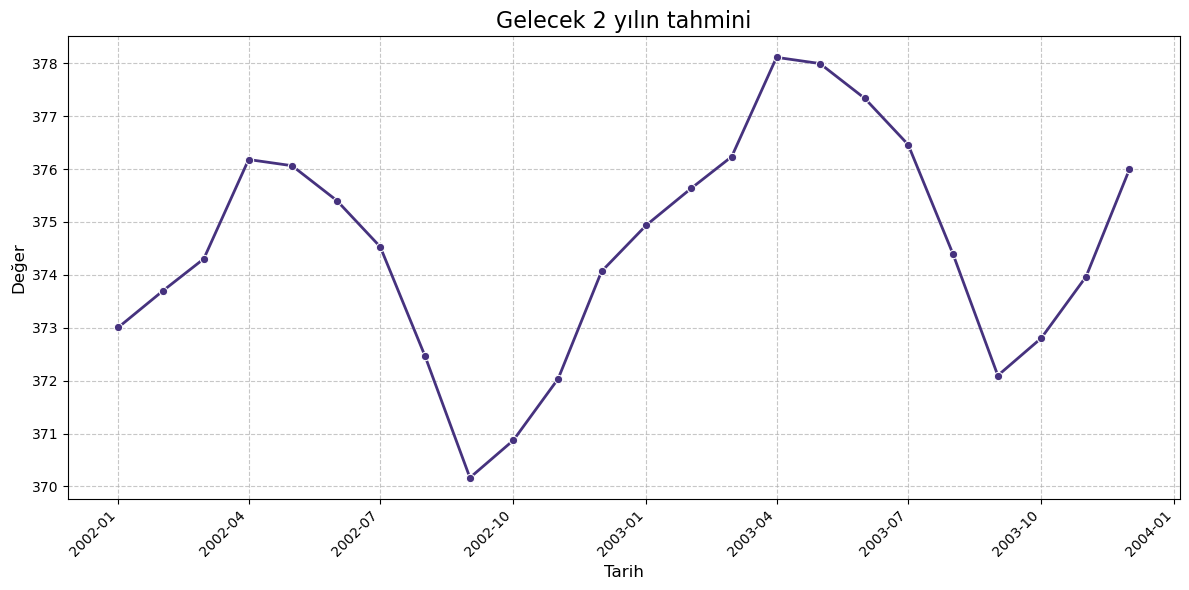

In [100]:
sns.set_palette("viridis")

# Plot the time series data with enhanced styling
plt.figure(figsize=(12, 6))
sns.lineplot(data=a, marker='o', linewidth=2)
plt.title('Gelecek 2 yılın tahmini', fontsize=16)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Değer', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

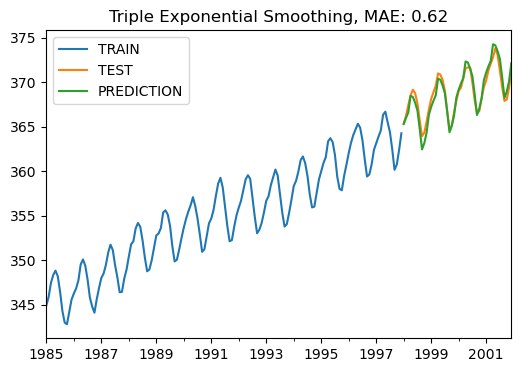

In [74]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing") 

In [79]:
y_pred

1998-01-01    365.283180
1998-02-01    365.977987
1998-03-01    366.577117
1998-04-01    368.454280
1998-05-01    368.337400
1998-06-01    367.678358
1998-07-01    366.804240
1998-08-01    364.736445
1998-09-01    362.439531
1998-10-01    363.145684
1998-11-01    364.309048
1998-12-01    366.338622
1999-01-01    367.214680
1999-02-01    367.909488
1999-03-01    368.508618
1999-04-01    370.385781
1999-05-01    370.268900
1999-06-01    369.609858
1999-07-01    368.735741
1999-08-01    366.667946
1999-09-01    364.371031
1999-10-01    365.077185
1999-11-01    366.240549
1999-12-01    368.270122
2000-01-01    369.146180
2000-02-01    369.840988
2000-03-01    370.440118
2000-04-01    372.317281
2000-05-01    372.200401
2000-06-01    371.541359
2000-07-01    370.667241
2000-08-01    368.599446
2000-09-01    366.302532
2000-10-01    367.008685
2000-11-01    368.172049
2000-12-01    370.201623
2001-01-01    371.077681
2001-02-01    371.772488
2001-03-01    372.371619
2001-04-01    374.248782


# Statistical Methods

In [70]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
warnings.filterwarnings('ignore')

In [61]:
# Veri Seti
# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

In [63]:
data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
train = y[:'1997-12-01']
test = y['1998-01-01':]

In [64]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################

In [65]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

In [66]:
arima_model.summary() # modelin istatistiki çıktısı

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Wed, 03 Jan 2024   AIC                           1157.537
Time:                        13:52:23   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
y_pred = arima_model.forecast(48)
y_pred = pd.Series(y_pred, index=test.index)
# pandas seririsne çevirme işlemini aşağıdaki görselleştirmeyi yapabilmek için yazdık çünki o fonksiyon 
# görselleştirme yapabilmek için bir pandas serisi istiyor 
y_pred

1998-01-01    365.558639
1998-02-01    366.300479
1998-03-01    366.721013
1998-04-01    366.959404
1998-05-01    367.094543
1998-06-01    367.171151
1998-07-01    367.214578
1998-08-01    367.239196
1998-09-01    367.253152
1998-10-01    367.261063
1998-11-01    367.265547
1998-12-01    367.268090
1999-01-01    367.269531
1999-02-01    367.270348
1999-03-01    367.270811
1999-04-01    367.271073
1999-05-01    367.271222
1999-06-01    367.271307
1999-07-01    367.271354
1999-08-01    367.271381
1999-09-01    367.271397
1999-10-01    367.271406
1999-11-01    367.271410
1999-12-01    367.271413
2000-01-01    367.271415
2000-02-01    367.271416
2000-03-01    367.271416
2000-04-01    367.271417
2000-05-01    367.271417
2000-06-01    367.271417
2000-07-01    367.271417
2000-08-01    367.271417
2000-09-01    367.271417
2000-10-01    367.271417
2000-11-01    367.271417
2000-12-01    367.271417
2001-01-01    367.271417
2001-02-01    367.271417
2001-03-01    367.271417
2001-04-01    367.271417


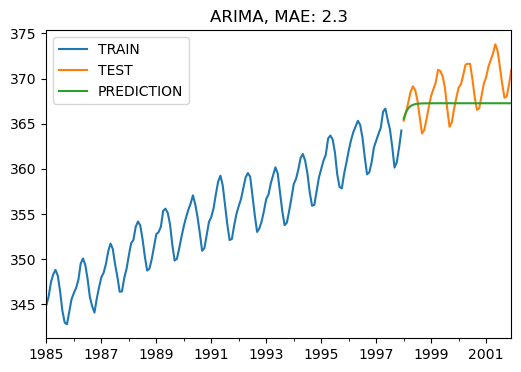

In [68]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "ARIMA")

In [62]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme) (1,1,1)
############################

In [63]:
############################
# AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme
############################

In [64]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

In [70]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order).fit(disp=0)
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [71]:
best_params_aic = arima_optimizer_aic(train, pdq) #en düşük aıc 2,1,3 bulundu benim bilgisyaraım bulamadı

Best ARIMANone AIC=inf


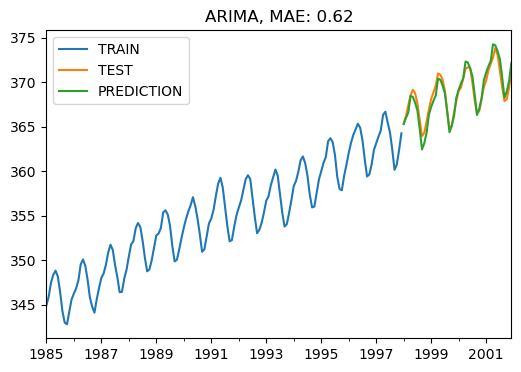

In [72]:
plot_co2(train, test, y_pred, "ARIMA")

In [73]:
##################################################
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)
##################################################

In [74]:
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

In [75]:
sarima_model = model.fit(disp=0)

In [76]:
y_pred_test = sarima_model.get_forecast(steps=48)

In [77]:
y_pred = y_pred_test.predicted_mean

In [78]:
y_pred = pd.Series(y_pred, index=test.index)

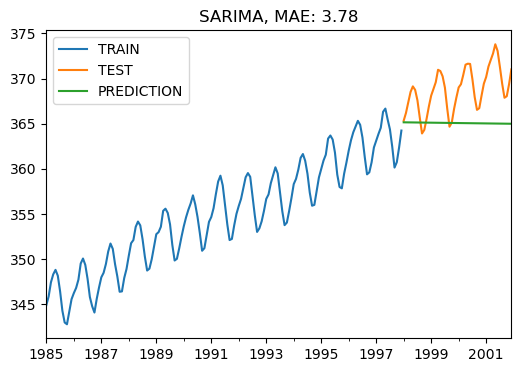

In [79]:
plot_co2(train, test, y_pred, "SARIMA")

In [80]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

In [81]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [82]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [83]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219681159
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880365
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925355716
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1900.7135266908233
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1606.8663715243347
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.0254009703658
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077276804098
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364744848
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.5679294412885
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.84475157225
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176947542
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1474.6659486169244
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6254.3198725450075
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602685074319
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6332845501656
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546906607
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:

In [90]:
############################
# Final Model
############################

In [91]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [92]:
y_pred_test = sarima_final_model.get_forecast(steps=48)

In [93]:
y_pred = y_pred_test.predicted_mean

In [94]:
y_pred = pd.Series(y_pred, index=test.index)

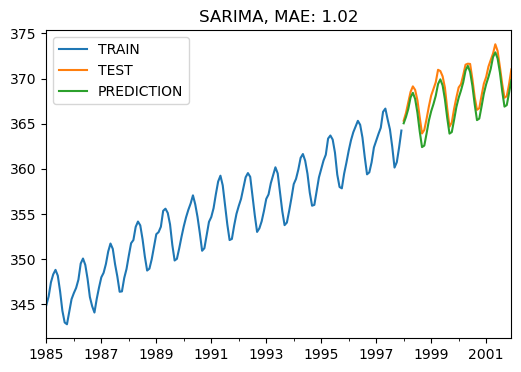

In [95]:
plot_co2(train, test, y_pred, "SARIMA")

In [96]:
##################################################
# BONUS: MAE'ye Göre SARIMA Optimizasyonu
##################################################

In [97]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [98]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [99]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.17909156740444
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.80332436976764
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.1508011904082025
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.821901832615656
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.3237250934317117
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279753051613056
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.9178691427671
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.40505999780726
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.9853394858905995
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765306215961874
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.944330754207788
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:350.8231031865059
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.674155328331301
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.5666945518191184
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.93154014

In [100]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [101]:
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

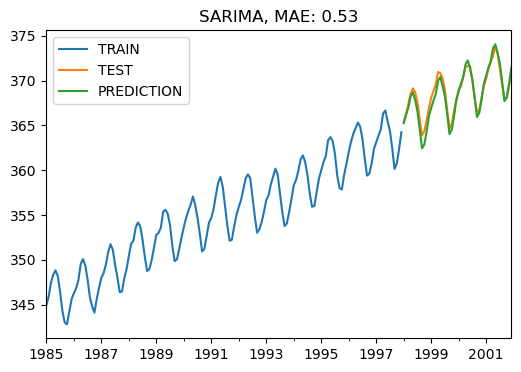

In [102]:
plot_co2(train, test, y_pred, "SARIMA")

In [103]:
############################
# Final Model
############################

In [104]:
model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [105]:
feature_predict = sarima_final_model.get_forecast(steps=6)
feature_predict = feature_predict.predicted_mean
feature_predict 

#6 aylık tahmin sonuçları

2002-01-01    371.930530
2002-02-01    372.718072
2002-03-01    373.585289
2002-04-01    374.494057
2002-05-01    375.101887
2002-06-01    374.687872
Freq: MS, Name: predicted_mean, dtype: float64

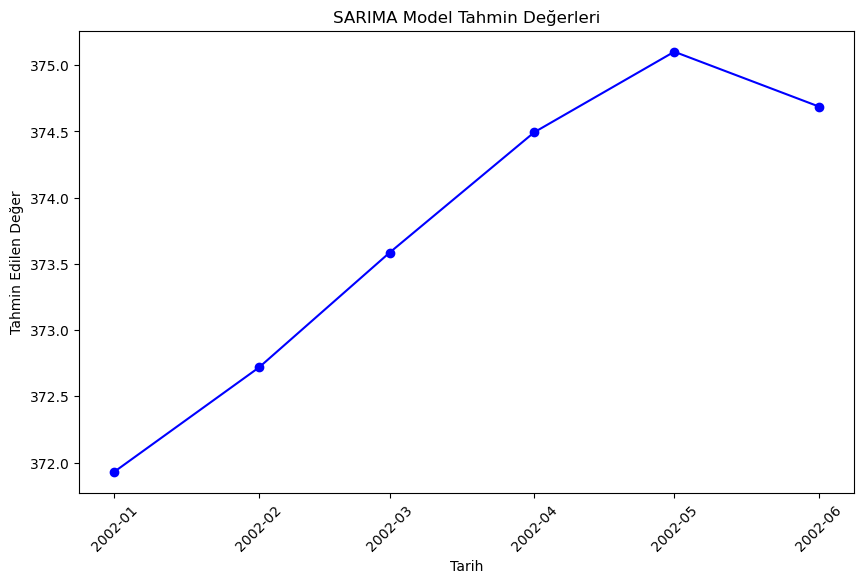

In [106]:
predicted_values = [371.930530, 372.718072, 373.585289, 374.494057, 375.101887, 374.687872]

# Tarih dizisi (bu örnek için varsayılan tarihleri kullanıyorum)
dates = ['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01']

# Tarih dizisini datetime formatına çevirme
dates = pd.to_datetime(dates)

# Grafiği oluşturma
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_values, marker='o', linestyle='-', color='b')

# Grafik başlığı ve eksen etiketleri ekleme
plt.title('SARIMA Model Tahmin Değerleri')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Değer')

# Tarihleri düzgün biçimde görüntüleme
plt.xticks(rotation=45)

# Grafiği gösterme
plt.show()

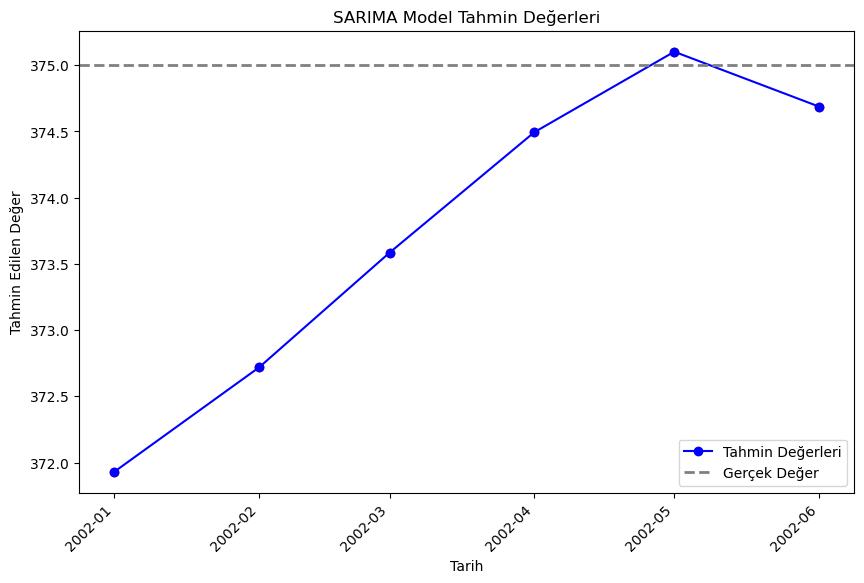

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

# Önceden tanımlanmış veriler
predicted_values = [371.930530, 372.718072, 373.585289, 374.494057, 375.101887, 374.687872]
dates = ['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01']
dates = pd.to_datetime(dates)

# Grafiği oluşturma ve boyutlandırma
plt.figure(figsize=(10, 6))

# Çizgi grafiği çizme
plt.plot(dates, predicted_values, marker='o', linestyle='-', color='b', label='Tahmin Değerleri')

# Grafik başlığı ve eksen etiketleri ekleme
plt.title('SARIMA Model Tahmin Değerleri')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Değer')

# Tarih etiketlerini düzgün biçimde görüntüleme ve etiketleri otomatik yerleştirme
plt.xticks(rotation=45, ha='right')

# İlgili noktaları vurgulama
plt.scatter(dates, predicted_values, color='red')

# Tahmin çizgisini daha belirgin yapma
plt.axhline(y=375, color='gray', linestyle='--', label='Gerçek Değer', linewidth=2)

# Raster arka planını kapatma
plt.grid(False)

# Grafik üzerindeki açıklamaları gösterme
plt.legend()

# Grafik gösterme
plt.show()


# AİR PASSENGER

In [112]:
df = pd.read_csv('airline-passengers.csv', parse_dates=True,index_col='month')

In [113]:
def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [115]:
df.shape

(144, 1)

In [116]:
df.head()

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


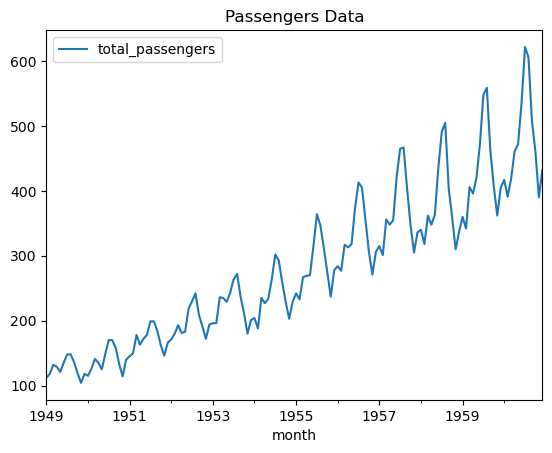

In [117]:
df[['total_passengers']].plot(title='Passengers Data')
plt.show()

In [120]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq='MS')

In [119]:
df.index.freq = "MS"

In [121]:
train = df[:120]
test = df[120:]

In [ ]:
#################################
# Single Exponential Smoothing
#################################

In [122]:
def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [123]:
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)
# best_alpha: 0.11 best_mae: 82.528

alpha: 0.01 mae: 190.1196
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


In [124]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)

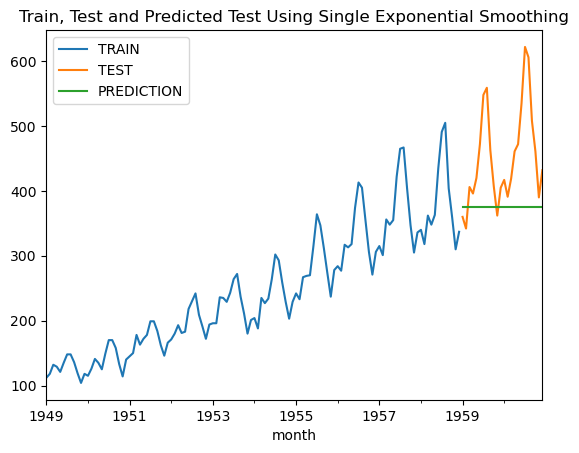

In [125]:
def plot_prediction(y_pred, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")

In [126]:
#################################
# Double Exponential Smoothing
#################################

def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [127]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

In [128]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)
# best_alpha: 0.01 best_beta: 0.11 best_mae: 54.1036

alpha: 0.01 beta: 0.01 mae: 54.9512
alpha: 0.01 beta: 0.11 mae: 54.1036
alpha: 0.01 beta: 0.21 mae: 55.5568
alpha: 0.01 beta: 0.31 mae: 57.3247
alpha: 0.01 beta: 0.41 mae: 57.7931
alpha: 0.01 beta: 0.51 mae: 57.9968
alpha: 0.01 beta: 0.61 mae: 57.9636
alpha: 0.01 beta: 0.71 mae: 57.5635
alpha: 0.01 beta: 0.81 mae: 57.3334
alpha: 0.01 beta: 0.91 mae: 57.8984
alpha: 0.11 beta: 0.01 mae: 55.0309
alpha: 0.11 beta: 0.11 mae: 58.4728
alpha: 0.11 beta: 0.21 mae: 69.6339
alpha: 0.11 beta: 0.31 mae: 72.555
alpha: 0.11 beta: 0.41 mae: 78.8168
alpha: 0.11 beta: 0.51 mae: 81.996
alpha: 0.11 beta: 0.61 mae: 77.2262
alpha: 0.11 beta: 0.71 mae: 71.5042
alpha: 0.11 beta: 0.81 mae: 69.0258
alpha: 0.11 beta: 0.91 mae: 67.8408
alpha: 0.21 beta: 0.01 mae: 57.1824
alpha: 0.21 beta: 0.11 mae: 74.992
alpha: 0.21 beta: 0.21 mae: 95.9492
alpha: 0.21 beta: 0.31 mae: 115.3164
alpha: 0.21 beta: 0.41 mae: 139.4303
alpha: 0.21 beta: 0.51 mae: 178.3759
alpha: 0.21 beta: 0.61 mae: 243.4543
alpha: 0.21 beta: 0.71 mae:

In [129]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)

In [130]:
y_pred = des_model.forecast(24)

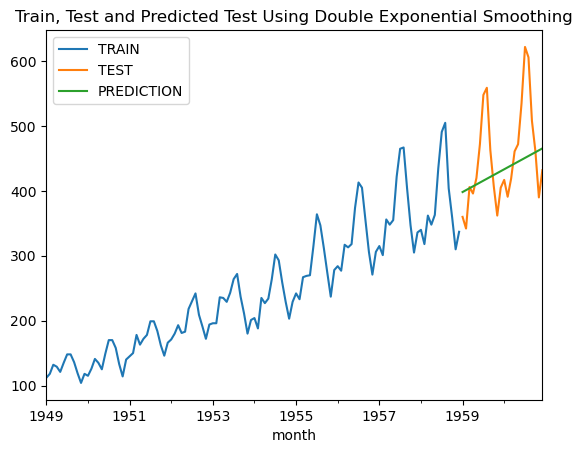

In [131]:
plot_prediction(y_pred, "Double Exponential Smoothing")

In [132]:
#################################
# Triple Exponential Smoothing (Holt-Winters)
#################################

In [137]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [138]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)

In [139]:
abg = list(itertools.product(alphas, betas, gammas))

In [140]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

[0.1, 0.1, 0.1, 36.83]
[0.1, 0.1, 0.3, 34.88]
[0.1, 0.1, 0.5, 35.91]
[0.1, 0.1, 0.7, 38.72]
[0.1, 0.1, 0.9, 42.55]
[0.1, 0.3, 0.1, 53.96]
[0.1, 0.3, 0.3, 53.0]
[0.1, 0.3, 0.5, 56.98]
[0.1, 0.3, 0.7, 61.38]
[0.1, 0.3, 0.9, 67.17]
[0.1, 0.5, 0.1, 56.77]
[0.1, 0.5, 0.3, 51.72]
[0.1, 0.5, 0.5, 53.39]
[0.1, 0.5, 0.7, 60.08]
[0.1, 0.5, 0.9, 79.29]
[0.1, 0.7, 0.1, 34.04]
[0.1, 0.7, 0.3, 25.93]
[0.1, 0.7, 0.5, 27.81]
[0.1, 0.7, 0.7, 27.91]
[0.1, 0.7, 0.9, 38.32]
[0.1, 0.9, 0.1, 26.87]
[0.1, 0.9, 0.3, 25.32]
[0.1, 0.9, 0.5, 53.88]
[0.1, 0.9, 0.7, 38.38]
[0.1, 0.9, 0.9, 17.78]
[0.3, 0.1, 0.1, 54.54]
[0.3, 0.1, 0.3, 38.34]
[0.3, 0.1, 0.5, 31.57]
[0.3, 0.1, 0.7, 30.99]
[0.3, 0.1, 0.9, 29.23]
[0.3, 0.3, 0.1, 72.71]
[0.3, 0.3, 0.3, 22.6]
[0.3, 0.3, 0.5, 11.99]
[0.3, 0.3, 0.7, 17.11]
[0.3, 0.3, 0.9, 22.32]
[0.3, 0.5, 0.1, 132.33]
[0.3, 0.5, 0.3, 25.74]
[0.3, 0.5, 0.5, 17.3]
[0.3, 0.5, 0.7, 38.38]
[0.3, 0.5, 0.9, 56.82]
[0.3, 0.7, 0.1, 288.32]
[0.3, 0.7, 0.3, 134.86]
[0.3, 0.7, 0.5, 96.77]
[0.3, 0.7, 

In [141]:
tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [142]:
y_pred = tes_model.forecast(24)

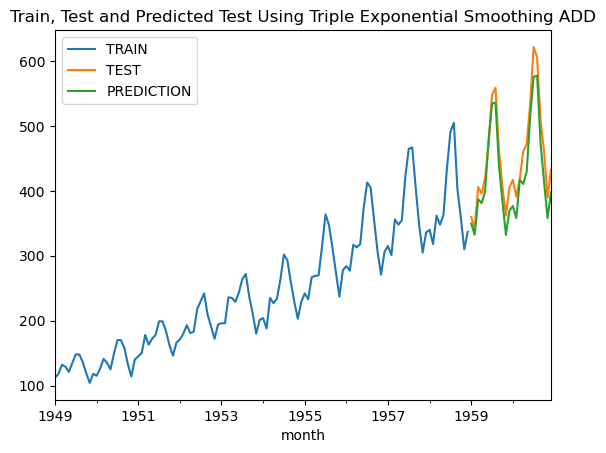

In [143]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

In [ ]:
##################################################
# SARIMA
##################################################

In [144]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [145]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


In [146]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1680.2792351899682
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1557.6320524366079
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1060.4792883426737
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1014.0696747520251
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1231.9865853985646
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1185.3010979099668
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:969.3781382611718
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:951.6145538304183
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1524.3620853405278
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1403.5942350721216
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:967.5225695583988
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:942.2425093047095
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1136.4998829474969
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1127.8397015940945
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:918.2233876025401
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:896.7127752587991
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1138.8088994229254
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC

In [147]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)

In [148]:
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)

68.57726545235921

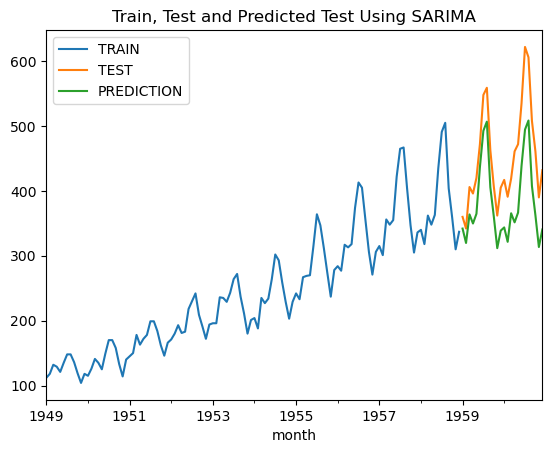

In [149]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")
# BURDA GÖÜKEN O Kİ BİR LEVEL YADA TREND PROBLEMİ VAR

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [150]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order


In [151]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:452.25
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:367.20954586119325
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:71.25
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:72.62972633862401
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:74.93611477700983
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:76.79702343790413
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:58.599738719849256
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.623362595882828
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:442.6732363260505
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:356.2897857331759
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:70.49252848330782
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:71.32051672251579
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:75.48449048494585
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:76.43328813611429
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:61.01388535672505
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:31.71537139829776
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:115.25
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:119.36368447774557
SARIMA(0, 1, 0)x(0, 1,

In [160]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)

30.623362595882828

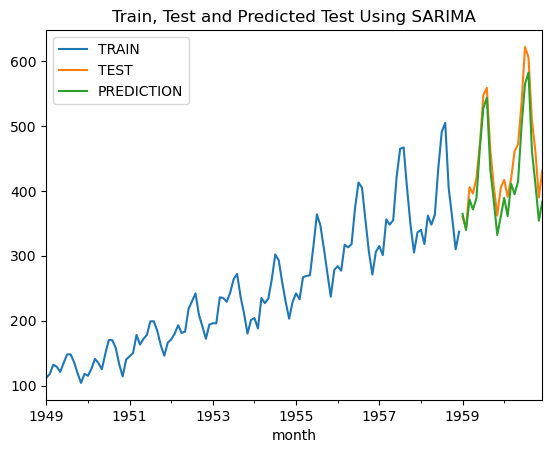

In [161]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

In [1]:
# Final model

tes_model_final = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

a = tes_model_final.forecast(6)
a

NameError: name 'ExponentialSmoothing' is not defined

<AxesSubplot:>

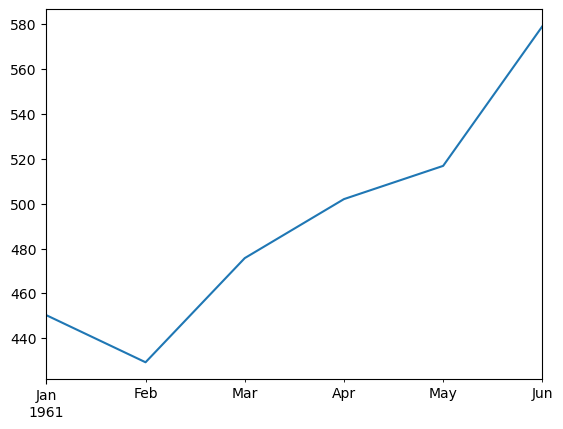

In [165]:
a.plot()

In [21]:
df = pd.read_csv('i.csv')

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
